# imu calibration

see `calibration.py` for clibration util

In [1]:
from scipy import io
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
from quaternion import Quaternion
from calibration import calibrate
%matplotlib inline

# read raw data
data_num = 1
imu = io.loadmat("imu/imuRaw"+str(data_num)+".mat")
accel_raw = imu["vals"][0:3,:].astype(float)
gyro_raw = imu["vals"][3:6,:].astype(float)
ts = imu["ts"][0,:].astype(float)
T = len(ts)
# take dt as average of time differences
dt = np.mean(np.diff(ts))

vicon = io.loadmat("vicon/viconRot"+str(data_num)+".mat")
vicon_rots = vicon["rots"].astype(float)
vicon_ts = vicon["ts"][0,:].astype(float)
vicon_T = len(vicon_ts)
vicon_dt = np.mean(np.diff(vicon_ts))

def raw_to_physical_meas(raw, beta, alpha):
    return (raw - beta) * ((3300.0) / (1023.0 * alpha))

def preprocess_imu(accel, gyro):
    '''
    iron out quirks in the imu data
    
    1. negate x, y in accel
    2. move z gyro to last row
    '''
    accel_out = np.zeros_like(accel)
    # 1. negate x, y in accel
    accel_out[0,:] = np.negative(accel[0,:])
    accel_out[1,:] = np.negative(accel[1,:])
    accel_out[2,:] = accel[2,:]
    
    # 2. switch gyro axes
    gyro_out = np.zeros_like(gyro)
    gyro_out[0,:] = gyro[1,:]
    gyro_out[1,:] = gyro[2,:]
    gyro_out[2,:] = gyro[0,:]
    
    return accel_out, gyro_out

def vicon_to_imu_frame_orientation(vicon_rots):
    # vicon rots are rotation matrices
    # create heading vectors from rotation matrices, and plot the x, y, z components
    heading = np.array([0, 0, 9.81])
    vicon_orientations = np.zeros((3, T))
    vicon_orientations = np.matmul(vicon_rots.T, heading).T
    
    return vicon_orientations

Text(0, 0.5, 'Angle (rad)')

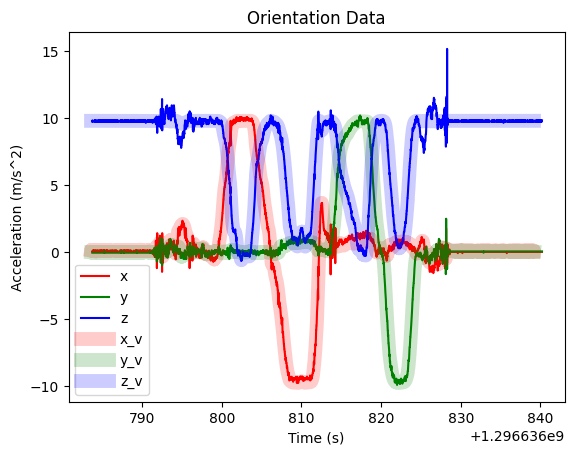

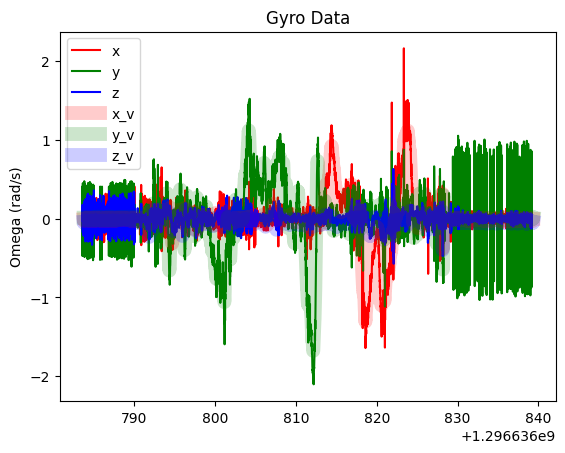

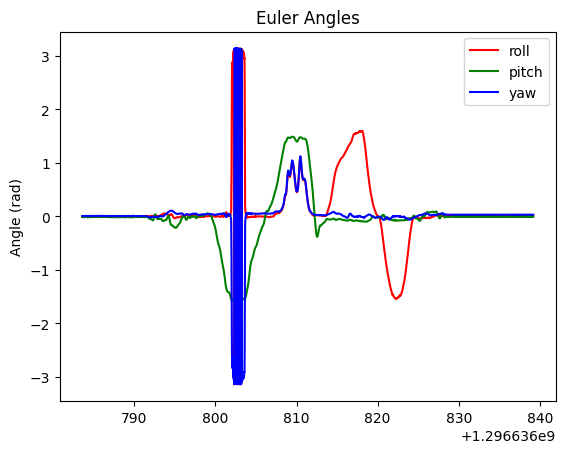

In [2]:
# preprocess
accel, gyro = preprocess_imu(accel_raw, gyro_raw)
vicon_orientations = vicon_to_imu_frame_orientation(vicon_rots)
vicon_quats = []
for i in range(vicon_T):
    vicon_quat = Quaternion()
    vicon_quat.from_rotm(vicon_rots[:,:,i])
    vicon_quats.append(vicon_quat)

vicon_omegas = np.zeros((3, vicon_T))
for i in range(1, vicon_T):
    vicon_quat = vicon_quats[i-1].inv() * vicon_quats[i]
    vicon_omegas[:,i] = vicon_quat.axis_angle(dt=vicon_dt)
    
    
# calibrate accel and gyro
accel_alphas = np.array([
        [34.5676],
        [34.2750],
        [34.4393]])
accel_betas = np.array(
        [[-511.1268],
        [-500.4646],
        [500.8905]])

gyro_alphas = np.array([250,250,250]).reshape(3,1)
gyro_betas = np.array([374.5,375.2,373.1]).reshape(3,1)

accel_calib = raw_to_physical_meas(accel, accel_betas, accel_alphas)
gyro_calib = raw_to_physical_meas(gyro, gyro_betas, gyro_alphas)

# plot out accel data
plt.figure()
plt.plot(ts, accel_calib[0,:], label="x", color="red")
plt.plot(ts, accel_calib[1,:], label="y", color="green")
plt.plot(ts, accel_calib[2,:], label="z", color="blue")
# plot out vicon orientation data
plt.plot(vicon_ts, vicon_orientations[0,:], label="x_v", color="red", alpha=0.2, linewidth=10)
plt.plot(vicon_ts, vicon_orientations[1,:], label="y_v", color="green", alpha=0.2, linewidth=10)
plt.plot(vicon_ts, vicon_orientations[2,:], label="z_v", color="blue", alpha=0.2, linewidth=10)
plt.legend()
plt.title("Orientation Data")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")

#plot out vicon omega data
plt.figure()
plt.plot(vicon_ts, vicon_omegas[0,:], label="x", color="red")
plt.plot(vicon_ts, vicon_omegas[1,:], label="y", color="green")
plt.plot(vicon_ts, vicon_omegas[2,:], label="z", color="blue")
# plot out gyro data
plt.plot(ts[:vicon_T], gyro_calib[0,:vicon_T], label="x_v", color="red", alpha=0.2, linewidth=10)
plt.plot(ts[:vicon_T], gyro_calib[1,:vicon_T], label="y_v", color="green", alpha=0.2, linewidth=10)
plt.plot(ts[:vicon_T], gyro_calib[2,:vicon_T], label="z_v", color="blue", alpha=0.2, linewidth=10)
plt.legend()
plt.title("Gyro Data")
plt.ylabel("Omega (rad/s)")

# plot out vicon euler angles. use vicon_quats[i].euler_angles() to get euler angles
plt.figure()
euler_angles = np.zeros((3, vicon_T))
for i in range(vicon_T):
    euler_angles[:,i] = vicon_quats[i].euler_angles()
plt.plot(vicon_ts, euler_angles[0,:], label="roll", color="red")
plt.plot(vicon_ts, euler_angles[1,:], label="pitch", color="green")
plt.plot(vicon_ts, euler_angles[2,:], label="yaw", color="blue")
plt.legend()
plt.title("Euler Angles")
plt.ylabel("Angle (rad)")

In [ ]:
# call calibration routine

beta_ref = np.array([375,375,375]).reshape(3,1)
alpha_ref = np.array([250,250,250]).reshape(3,1)
alpha_gyro, beta_gyro = calibrate(gyro, vicon_omegas, alpha_ref, beta_ref, r=1)
print("alpha gyro: ", alpha_gyro.data)
print("beta gyro: ", beta_gyro.data)